In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/IPOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Creating JRA55-do-1-5-0 sea surface temperature anomalies

In [2]:
%%time
# ------------------------------------------------------------------------------------------------------------ #
# --- which forcing to use, either JRA55-do-1-3, JRA55-do-1-4-0 or JRA55-do-1-5-0                              #
forcing = '1-5-0'                                                                                              #
period = ['1958','2019','2021','2023'] # which period to consider for anomaly calculation    #
version = ['v20200916', 'v20210315', 'latest'] #'v20190429'                                                    #
# ------------------------------------------------------------------------------------------------------------ #
base  = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
base2 = '/g/data/ik11/inputs/JRA-55/JRA55-do-' + forcing + '-1/mirror/'
out   = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'
var   = ['huss','psl','tas','ts', 'uas','vas','prra','prsn','rlds','rsds','friver','tos','taux', 'tauy'] # only eight of the variables I used in my Msc

for i in range(len(var)-2): # loop through all variables except the two wind stress components
    if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']; short = 'gr'
    if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['01010130','12312230']; short = 'gr'
    if var[i] in ['tos']:                               domain = 'ocean/day/';   timestep = ['0101','1231']; short = 'gn'
    if var[i] in ['friver']:                            domain = 'land/day/';   timestep = ['0101','1231']; short = 'gr'
    print(domain+var[i])

    # filenames for output files
    f1 = out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[i]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
    f2 = out + 'monthly_anom/JRA55-do-'+forcing+'_'+var[i]+'_monthly_anom_'+period[0]+'-'+period[3]+'.nc'
    if os.path.isfile(f2) == True: # skip iteration if final .nc file already exists
        continue               

# Step I: merge 01-Jan-1958 to 31-Dec-2019 files and create monthly mean fields
    cdo.monmean(input = '-mergetime ' + base + domain + var[i] + '/'+short+'/'+version[0]+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '_'+short+'_{' + period[0] + '..' + period[1] + '}*',
                output = f1, force=False)
# Step II: the first extension for 01-Jan-2020 to 31-Dec-2020
    cdo.monmean(input = base2 + domain + var[i] + '/'+short+'/'+version[1]+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '-1_'+short+'_2020*',
                output = f1.replace('1958-2019', '2020'), force=False)
# Step III: the second extension for years 01-Jan-2021 to 31-Dec-2020
    cdo.monmean(input = '-mergetime ' + base2 + domain + var[i] + '/'+short+'/'+version[2]+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '-1_'+short+'_{' + period[2] + '..' + period[3] + '}*',
                output = f1.replace('1958-2019', '2021-2023'), force=False)
# Step IV: merge the original JRA55-do file and the extensions
    cdo.mergetime(input = f1 + ' ' + f1.replace('1958-2019', '2020') + ' ' + f1.replace('1958-2019', '2021-2023'), 
                  output = f1.replace('1958-2019', '1958-2023'), force=False)
# Step VI: create monthly anomalies
    field = xr.open_dataset(f1.replace('1958-2019', '1958-2023'))
    field = (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[i]].drop('month')
    field.to_netcdf(f2, encoding={'time': {'dtype': 'i4'}}) # save as netcdf file with correct time encoding

# # Step VI: create monthly anomalies
#     cdo.yseassub(input = f1.replace('1958-2019', '1958-2023') + ' -yseasavg -selyear,1971/2000 ' + f1.replace('1958-2019', '1958-2023'), 
#                  output = f2, force=False) 
# Step V: remove the unnecessary files 
    os.system('rm -r ' + f1.replace('1958-2019', '2020') + ' ' + f1.replace('1958-2019', '2021-2023')) # add the 1958-2019 fields to the removal once I am sure all correct
    
    print('--- --- --- --- ---') # this indicates, the loop for a specific variable is now done
# Total Walltime for all 11 vars: 4h 3s
# Wall time: 29min 30s when redoing the anomaly calculations

atmos/3hrPt/huss
atmos/3hrPt/psl
atmos/3hrPt/tas
atmos/3hrPt/ts
atmos/3hrPt/uas
atmos/3hrPt/vas
atmos/3hr/prra
atmos/3hr/prsn
atmos/3hr/rlds
atmos/3hr/rsds
land/day/friver
ocean/day/tos
CPU times: user 140 ms, sys: 1.13 s, total: 1.28 s
Wall time: 1.15 s


### Calculating the IPO index

In [3]:
%%time
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/'
vars = ['tos', 'psl', 'uas', 'vas']

# SST_mean = xr.open_mfdataset(base + '/ocean/day/tos/gn/v20200916/' + 'tos_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gn_*.nc').tos.resample(time="1MS").mean(dim="time")
# SST_anom = (SST_mean.groupby("time.month") - (SST_mean[156:505,:,:].groupby("time.month").mean("time")))[0:722,:,:] # for the climatology, select Jan 1971 to Jan 2000. 
#                                                                                                                     # for the full time series, select 1958-2019 (61 years)
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
jra55_ssta = xr.open_dataset(base + 'JRA55-do-1-5-0_tos_monthly_anom_1958-2023.nc').tos # temperature ocean surface = SST

# The index is based on the difference between the SSTA averaged over the central equatorial Pacific 
# and the average of the SSTA in the Northwest and Southwest Pacific. The regions used to calculate 
# the index shown in the map above and are:          Region 1: 25°N–45°N, 140°E–145°W
#                                                    Region 2: 10°S–10°N, 170°E–90°W
#                                                    Region 3: 50°S–15°S, 150°E–160°W 
sel_lat = [ 115,  135,   79,  100,   39,   74]       # [25°N, 45°N, 10°S, 10°N, 50°S, 15°S]
sel_lon = [  140,   215,   170,   270,   150,   200] # [140°E, 215°E, 170°E, 270°E, 150°E, 200°E]
IPO_r1 = jra55_ssta[:,sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean(['lat', 'lon']) 
IPO_r2 = jra55_ssta[:,sel_lat[2]:sel_lat[3], sel_lon[2]:sel_lon[3]].mean(['lat', 'lon']) 
IPO_r3 = jra55_ssta[:,sel_lat[4]:sel_lat[5], sel_lon[4]:sel_lon[5]].mean(['lat', 'lon']) 

TPI_JRA55_raw = (IPO_r2 - (IPO_r1 + IPO_r3)/2) # calculate tripole index

CPU times: user 1.71 s, sys: 1.04 s, total: 2.75 s
Wall time: 10.5 s


### Tripole index from ERA5 instead

In [4]:
%%time
import glob
base_era = '/g/data/rt52/era5/single-levels/monthly-averaged/sst/'
filenames = glob.glob(base_era + '*/*.nc')  # list of all .nc files available in the subfolders
era5_sst = xr.open_mfdataset(filenames).sst # open all the files
era5_ssta = (era5_sst.groupby("time.month") - (era5_sst[144:493,:,:].groupby("time.month").mean("time"))) # for the climatology, select Jan 1971 to Jan 2000 
era5_ssta.attrs=dict(Note='Anomalies relative to Jan 1971 to Jan 2000 climatology')
if not os.path.exists('/g/data/e14/mv7494/ERA5/monthly_anom/ERA5_sst_monthly_anom_1959-2021.nc'):
    print('file not yet saved, doing that now')
    era5_ssta.to_netcdf('/g/data/e14/mv7494/ERA5/monthly_anom/ERA5_sst_monthly_anom_1959-2021.nc')
print('Saving anomalies as .nc file done now')
# Wall time: 1min 38s

Saving anomalies as .nc file done now
CPU times: user 17.7 s, sys: 9.67 s, total: 27.4 s
Wall time: 57.9 s


In [5]:

# Tripole Index Region
# R1: 25°N–45°N, 140°E–145°W
# R2: 10°S–10°N, 170°E–90°W
# R3: 50°S–15°S, 150°E–160°W

sel_lat = [180, 260, 180, 260, 320, 400, 320, 400, 420, 560, 420, 560]
sel_lon = [1280, 1440, 0, 140, 1400, 1440, 0, 360, 1320, 1440, 0, 80]

IPO_r1 = era5_ssta[:,sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[2]:sel_lat[3],sel_lon[2]:sel_lon[3]].mean(['longitude', 'latitude'])
IPO_r2 = era5_ssta[:,sel_lat[4]:sel_lat[5],sel_lon[4]:sel_lon[5]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[6]:sel_lat[7],sel_lon[6]:sel_lon[7]].mean(['longitude', 'latitude'])
IPO_r3 = era5_ssta[:,sel_lat[8]:sel_lat[9],sel_lon[8]:sel_lon[9]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[10]:sel_lat[11],sel_lon[10]:sel_lon[11]].mean(['longitude', 'latitude'])
TPI_ERA5_raw = (IPO_r2 - (IPO_r1 + IPO_r3)/2)[:768] # calculate the tripole index and select 1959-01-01 to 2022-12-01
TPI_ERA5_raw

<xarray.DataArray 'sst' (time: 768)>
dask.array<getitem, shape=(768,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [6]:
a = np.linspace(0,27,28) # example of time series
def chunker(seq, size): # function that lets me loop through a time series in chunks of x values 
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
for group in chunker(a, 10): # select chunks of 10
   print(repr(group),)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])
array([20., 21., 22., 23., 24., 25., 26., 27.])


In [7]:
base2 = '/g/data/e14/mv7494/'
df = pd.read_fwf(base2 + 'tpi.timeseries.ersstv5.data') # read text file into pandas DataFrame
df = df.iloc[104:169,:]
# df.rename(columns={'index': 'Index'}, inplace=True)
df = df.set_axis(['Year', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'], axis=1) # replace column headers
df

,Year,a,b,c,d,e,f,g,h,i,j,k,l
104,1958,1.266,1.041,0.664,0.585,0.694,0.605,0.343,0.329,0.177,0.015,0.199,0.387
105,1959,0.358,0.161,-0.020,0.147,0.063,0.096,-0.242,-0.191,-0.322,0.047,-0.070,-0.191
106,1960,-0.084,-0.155,0.021,0.127,-0.048,-0.121,-0.396,-0.139,-0.397,-0.335,-0.359,-0.066
107,1961,0.182,0.222,-0.030,0.017,-0.324,-0.288,-0.661,-0.695,-0.862,-0.992,-0.517,-0.678
108,1962,-0.680,-0.524,-0.616,-0.685,-1.008,-0.978,-0.874,-0.496,-0.830,-0.886,-0.689,-0.653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,2018,-1.025,-1.027,-1.069,-0.732,-0.638,-0.542,-0.287,-0.225,-0.147,-0.024,0.004,0.119
165,2019,0.016,-0.088,0.017,0.084,0.117,-0.057,-0.173,-0.390,-0.371,-0.198,-0.035,-0.079
166,2020,-0.160,-0.283,-0.331,-0.077,-0.429,-0.726,-0.858,-1.100,-1.360,-1.393,-1.627,-1.274
167,2021,-1.260,-1.127,-0.989,-0.979,-1.000,-0.865,-0.897,-0.739,-1.051,-1.329,-1.597,-1.757


In [8]:
# rename the column to year
# reset index
# df = df.rename(columns={'index': 'Index'}, inplace=True)
df = df.drop(['Year'], axis=1)
df.index.names = ['Index']
df

,a,b,c,d,e,f,g,h,i,j,k,l
Index,,,,,,,,,,,,
104,1.266,1.041,0.664,0.585,0.694,0.605,0.343,0.329,0.177,0.015,0.199,0.387
105,0.358,0.161,-0.020,0.147,0.063,0.096,-0.242,-0.191,-0.322,0.047,-0.070,-0.191
106,-0.084,-0.155,0.021,0.127,-0.048,-0.121,-0.396,-0.139,-0.397,-0.335,-0.359,-0.066
107,0.182,0.222,-0.030,0.017,-0.324,-0.288,-0.661,-0.695,-0.862,-0.992,-0.517,-0.678
108,-0.680,-0.524,-0.616,-0.685,-1.008,-0.978,-0.874,-0.496,-0.830,-0.886,-0.689,-0.653
...,...,...,...,...,...,...,...,...,...,...,...,...
164,-1.025,-1.027,-1.069,-0.732,-0.638,-0.542,-0.287,-0.225,-0.147,-0.024,0.004,0.119
165,0.016,-0.088,0.017,0.084,0.117,-0.057,-0.173,-0.390,-0.371,-0.198,-0.035,-0.079
166,-0.160,-0.283,-0.331,-0.077,-0.429,-0.726,-0.858,-1.100,-1.360,-1.393,-1.627,-1.274


In [9]:
df2 = df.melt(var_name='Month', value_name="Value", ignore_index = False).sort_values(['Index', 'Month']) # melt df into a long format
# df2.Month = pd.to_numeric(df2.Month, errors='coerce')
# TPI_NOAA_raw = df2['Value'].to_numpy()
a = df2.iloc[:,1].to_numpy()

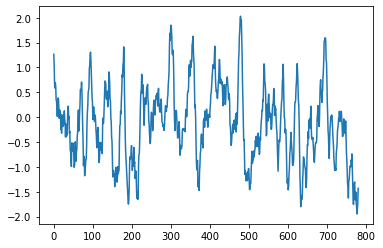

In [10]:
TPI_NOAA_raw = np.zeros(len(a))
for f in range(len(a)):
    TPI_NOAA_raw[f] = a[f]
plt.plot(TPI_NOAA_raw)

CPU times: user 26.7 ms, sys: 6.52 ms, total: 33.2 ms
Wall time: 27.5 ms


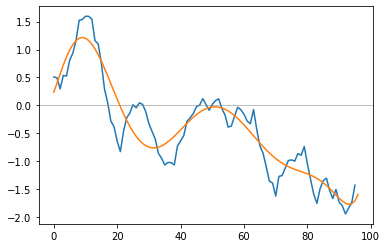

In [11]:
%%time
# fitting a polynomial for the NOAA time series from 2012-2022

length = 96
time = np.linspace(0,length,length)
TPI_NOAA_short = TPI_NOAA_raw[-length:] 
plt.plot(TPI_NOAA_short[-length:]) # 2013-03-15 to 2022-12-15
plt.axhline(0, c='grey', linewidth=.5) # last nine years: 2013 to 2022

z1 = np.polyfit(time, TPI_NOAA_short, 8) # only consider the non-NAN values

# z1 = np.polyfit(time,OHC_ctrl.values, 1) # polyfit for values unequal NaN
p1 = np.poly1d(z1) # construct the polynomial 
plt.plot(time,p1(time))

### Plotting routine IPO tripole index

CPU times: user 21 s, sys: 2.07 s, total: 23.1 s
Wall time: 30.5 s


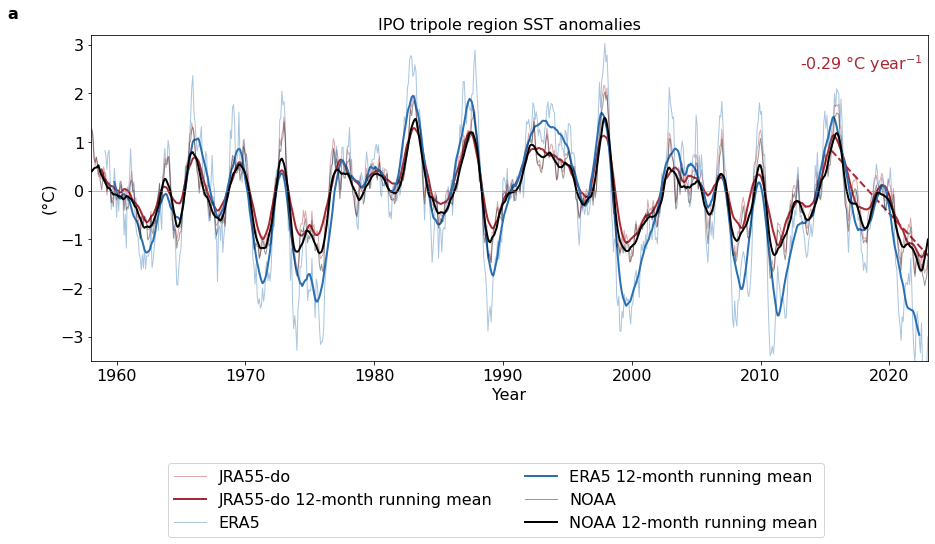

In [12]:
%%time
# -------------------------------------------------------------------------------- #
trend_period = 8 # [years] specify over which period to calculate the linear trend #
# -------------------------------------------------------------------------------- #

fig = plt.figure(figsize=(15,6))
time = np.linspace(1958.08,2023.41,785)
ax1 = plt.subplot(1,1,1)
# time series using JRA55-do ----------------------------------------------------------------------------------------------------------------- #
plt.plot(time, TPI_JRA55_raw, label='JRA55-do', c=rotblau[3], alpha=.4, linewidth=1)
plt.plot(time, TPI_JRA55_raw.rolling(time=18, center=True).mean(), label='JRA55-do 12-month running mean', c=rotblau[3], linewidth=2)

# calculate the linear trend over the last 8 years
z1 = np.polyfit(time[-(trend_period*12):], TPI_JRA55_raw[-(trend_period*12):], 1) # calculate first (linear) polynomial fit in units of [years]
p1 = np.poly1d(z1) # construct the polynomial 
plt.plot(time[-(trend_period*12):],p1(time[-(trend_period*12):]), c = rotblau[3], linewidth=2, linestyle = '--') # plot trend line
plt.text(time[-125], 2.5, str(np.round(p1[1], 2)) + ' °C year$^{-1}$', fontsize=16, c = rotblau[3]) # add trend value as text

# ax1.axvspan(1958, 1979, color=rotblau[12], alpha=.3) # shade period 
# ax1.axvspan(1979, 1998, color=rotblau[8], alpha=.3) 
# ax1.axvspan(1998, 2018, color=rotblau[12], alpha=.3)

# ax1.hlines(np.mean(TPI_JRA55_raw[0:252]).values, xmin=1958, xmax=1979, linewidth=2, color = rotblau[16])
# plt.text(1960, -1.5, str(np.round(np.mean(TPI_JRA55_raw[0:252]).values,2)) +' °C', fontsize=16, c = rotblau[16])

# ax1.hlines(np.mean(TPI_JRA55_raw[253:480]).values, xmin=1979, xmax=1997, linewidth=2, color = rotblau[4])
# plt.text(1980, -1.5, str(np.round(np.mean(TPI_JRA55_raw[253:480]).values,2)) +' °C', fontsize=16, c = rotblau[4])

# ax1.hlines(np.mean(TPI_JRA55_raw[481:]).values, xmin=1997, xmax=2018, linewidth=2, color = rotblau[16])
# plt.text(2001, -1.5, str(np.round(np.mean(TPI_JRA55_raw[481:]).values,2)) +' °C', fontsize=16, c = rotblau[16])

# time series using ERA5 data instead ---------------------------------------------------------------------------------------------------------- #
time2 = np.linspace(1959.08,2023,768)
plt.plot(time2, TPI_ERA5_raw, label='ERA5', c=rotblau[17], alpha=.4, linewidth=1)
plt.plot(time2, TPI_ERA5_raw.rolling(time=18, center=True).mean(), label='ERA5 12-month running mean', c=rotblau[17], linewidth=2)

# time series using NOAA data instead ---------------------------------------------------------------------------------------------------------- #
time3 = np.linspace(1958.08,2023,780)
plt.plot(time3, TPI_NOAA_raw, label='NOAA', c='k', alpha=.4, linewidth=1)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w # mode = 'same' to retain original array length
plt.plot(time3, moving_average(TPI_NOAA_raw, 12), label='NOAA 12-month running mean', c='k', linewidth=2)

plt.title('IPO tripole region SST anomalies', fontsize=16); plt.axhline(0, c='grey', linewidth=.5)
ax1.text(-.1, 1.05, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold panel index letter at the top
plt.xticks(fontsize=16); plt.yticks(fontsize=16) # fontsize of ticks
plt.xlabel('Year', fontsize=16); plt.ylabel('(°C)', fontsize=16) # ticklabels
plt.xlim(1958, 2023) # center on axis with data
plt.ylim(-3.5,3.2)

handles, labels = ax1.get_legend_handles_labels() # adding a legend outside the plot
fig.legend(handles, labels, fontsize=16, ncol=2, bbox_to_anchor=(.5, -.3), loc='lower center')

# --- saving as 300 dpi .PNG image in specified folder --------------------- #
plt.savefig(save + 'IPO_index_from_JRA55-do_1958-2018', 
            dpi=300, facecolor='w',                                          #
            edgecolor='w', orientation='landscape',                          #
            format=None, transparent=False, bbox_inches='tight',             #
            pad_inches=0.1, metadata=None)                                   #
# --- end of script -------------------------------------------------------- # 
# Wall time: 21.1 s

CPU times: user 49.6 ms, sys: 2.46 ms, total: 52.1 ms
Wall time: 47.4 ms


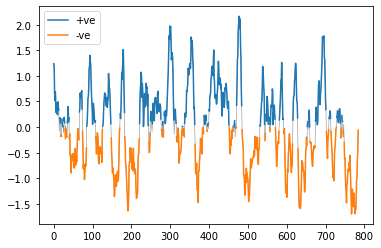

In [20]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
IPO_positive = TPI_JRA55_raw.where(TPI_JRA55_raw > 0, np.nan) # replace all zeroes by nan
IPO_negative = TPI_JRA55_raw.where(TPI_JRA55_raw < 0, np.nan) 
plt.plot(TPI_JRA55_raw, c='grey', linewidth=.5); plt.plot(IPO_positive, label='+ve'); plt.plot(IPO_negative, label='-ve'); plt.legend()

#### define the input for the figure                              ####
# -- state here which time series to use for the spatial patterns -- #
# only use time series until December 2022 as Andrew noted the last extension bit is of low quality
# time_series = TPI_JRA55_raw[0:780]; suffix = 'full_ts'; filename_extension = ' for the full time series'                  #
time_series = IPO_positive[0:780]; suffix = 'positive_ts'; filename_extension = ' when time series is positive'         #
# time_series = -IPO_negative[0:780]; suffix = 'negative_ts'; filename_extension = ' when time series is negative'         # NOTE: negative sign here for the time series, so that the spatial patterns show the La Nina-like Amundsen Sea Low deepening anomalies as in Fig. S7 of the ENSO-Antarctica GRL manuscript (Huguenin et al., 2023)
# ------------------------------------------------------------------ # 

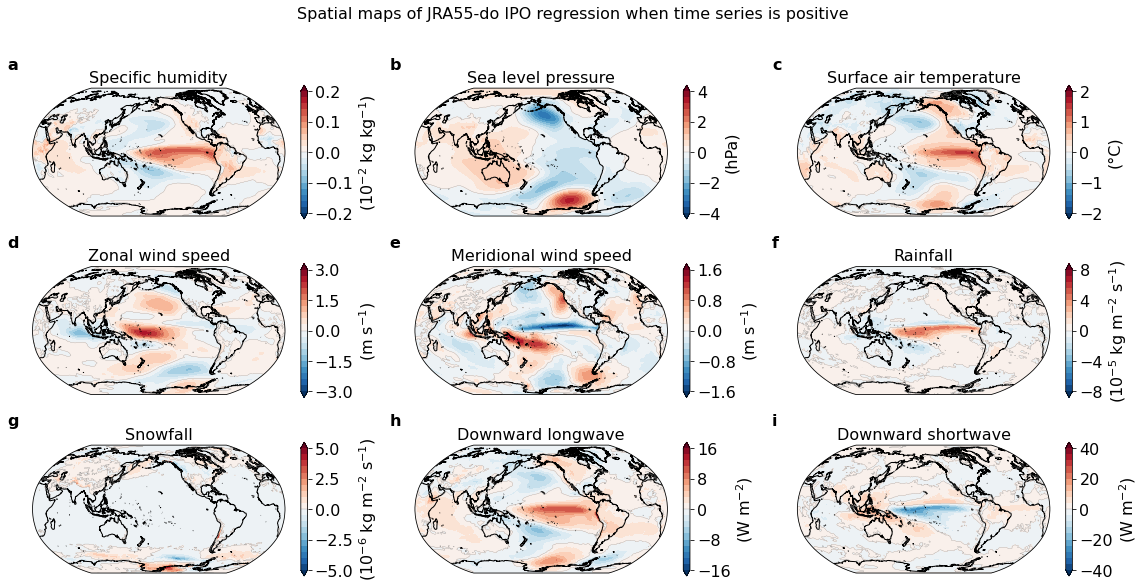

In [21]:
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
vars = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']
var  = ['huss', 'psl', 'tas', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds']
var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
var_units = ['10$^{-2}$ kg kg$^{-1}$', 'hPa', '°C', 'm s$^{-1}$', 'm s$^{-1}$',
             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$', 'W m$^{-2}$', 'W m$^{-2}$', 'kg m$^{-2}$ s$^{-1}$']

# (16,9)
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

for v in range(9): # loop through all variables
    # load in the data
    if v <= 8: 
        field = xr.open_dataset(base + 'JRA55-do-1-5-0_' + var[v] +'_monthly_anom_1958-2023.nc')[var[v]]
        field = field[:780,:,:] # only take Jan-1958 to Dec-2022 as the last few data points are of low quality according to Andrew Kiss

        ### Regressing the time series onto the spatial SLP anomalies

        field['time'] = time_series.time # copy over time structure, i.e., shift time axis by 1:30 hrs in SLP_anom so they align
        field = ((field * time_series) / np.std(time_series)).mean(['time']) # do regression

    # IPO-scale colour bars
    # if v == 0: scale = 1e2;  ticks = np.linspace(-.1,.1,21)   # huss
    # if v == 1: scale = 1e-2; ticks = np.linspace(-2,2,21)   # psl -> convert to hPa
    # if v == 2: scale = 1;    ticks = np.linspace(-1,1,21)     # tas
    # if v == 3: scale = 1;    ticks = np.linspace(-1.5,1.5,21)     # uas
    # if v == 4: scale = 1;    ticks = np.linspace(-.75,.75,21) # vas
    # if v == 5: scale = 1e5;  ticks = np.linspace(-4,4,21)     # prrn 
    # if v == 6: scale = 1e6;  ticks = np.linspace(-2.5,2.5,21)     # prsn
    # if v == 7: scale = 1;    ticks = np.linspace(-7.5,7.5,21)   # rlds
    # if v == 8: scale = 1;    ticks = np.linspace(-20,20,21)   # rsds
    # # if v == 9: scale = 1e-4; ticks = np.linspace(-5,5,21)   # friver   

    # ENSO-scale colour bars which are twice as big
    if v == 0: scale = 1e2;  ticks = np.linspace(-.2,.2,21)   # huss
    if v == 1: scale = 1e-2; ticks = np.linspace(-4,4,21)   # psl -> convert to hPa
    if v == 2: scale = 1;    ticks = np.linspace(-2,2,21)     # tas
    if v == 3: scale = 1;    ticks = np.linspace(-3,3,21)     # uas
    if v == 4: scale = 1;    ticks = np.linspace(-1.6, 1.6,21) # vas
    if v == 5: scale = 1e5;  ticks = np.linspace(-8,8,21)     # prrn 
    if v == 6: scale = 1e6;  ticks = np.linspace(-5,5,21)     # prsn
    if v == 7: scale = 1;    ticks = np.linspace(-16,16,21)   # rlds
    if v == 8: scale = 1;    ticks = np.linspace(-40,40,21)   # rsds
    
    ax1 = plt.subplot(3,3,v+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    # ------------------------------------ #
    p1  = (field*scale).plot.contourf(ax=ax1, levels = ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = (field*scale).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.55, orientation='vertical'); 
    cb.set_label(label='('+var_units[v]+')', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(var_titles[v], fontsize=16)
    fancy_plot(ax1)
    ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Spatial maps of JRA55-do IPO regression' + filename_extension, fontsize=16)
    
    if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
    if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])
    
    # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    plt.savefig(save + 'IPO_regression_fields_Robinson_JRA55-do-1-5-0_' + suffix, 
                dpi=300, facecolor='w',                                          #
                edgecolor='w', orientation='landscape',                          #
                format=None, transparent=False, bbox_inches='tight',             #
                pad_inches=0.1, metadata=None)                                   #
    # --- end of script -------------------------------------------------------- # 
# Wall time: 2min 2s

### EOF analysis of IPO SST regions

CPU times: user 82.9 ms, sys: 11.2 ms, total: 94.1 ms
Wall time: 83.4 ms


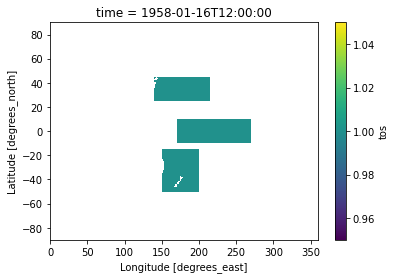

In [15]:
%%time
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/'
vars = ['tos', 'psl', 'uas', 'vas']

# SST_mean = xr.open_mfdataset(base + '/ocean/day/tos/gn/v20200916/' + 'tos_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gn_*.nc').tos.resample(time="1MS").mean(dim="time")
# SST_anom = (SST_mean.groupby("time.month") - (SST_mean[156:505,:,:].groupby("time.month").mean("time")))[0:722,:,:] # for the climatology, select Jan 1971 to Jan 2000. 
#                                                                                                                     # for the full time series, select 1958-2019 (61 years)
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
jra55_ssta = xr.open_dataset(base + 'JRA55-do-1-5-0_tos_monthly_anom_1958-2023.nc').tos

# The index is based on the difference between the SSTA averaged over the central equatorial Pacific 
# and the average of the SSTA in the Northwest and Southwest Pacific. The regions used to calculate 
# the index shown in the map above and are:          Region 1: 25°N–45°N, 140°E–145°W
#                                                    Region 2: 10°S–10°N, 170°E–90°W
#                                                    Region 3: 50°S–15°S, 150°E–160°W 
sel_lat = [ 115,  135,   79,  100,   39,   74]       # [25°N, 45°N, 10°S, 10°N, 50°S, 15°S]
sel_lon = [  140,   215,   170,   270,   150,   200] # [140°E, 215°E, 170°E, 270°E, 150°E, 200°E]
IPO_r1 = jra55_ssta[:,sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
IPO_r2 = jra55_ssta[:,sel_lat[2]:sel_lat[3], sel_lon[2]:sel_lon[3]]
IPO_r3 = jra55_ssta[:,sel_lat[4]:sel_lat[5], sel_lon[4]:sel_lon[5]] 

ds = jra55_ssta[0,:,:] # copy structure of data for IPO mask
# select the three IPO regions and mask out data outside the region with zero
ds1 = (ds.where(ds.lat> 25).where(ds.lat< 45).where(ds.lon>140).where(ds.lon<215)).notnull().astype('int')
ds2 = (ds.where(ds.lat>-10).where(ds.lat< 10).where(ds.lon>170).where(ds.lon<270)).notnull().astype('int')
ds3 = (ds.where(ds.lat>-50).where(ds.lat<-15).where(ds.lon>150).where(ds.lon<200)).notnull().astype('int')
IPO_mask = (ds1 + ds2 + ds3) # combine the three region to one mask
IPO_mask = IPO_mask.where(IPO_mask != 0) # replace all zero with nan
IPO_mask.plot()

In [16]:
%%time
modes = 3 # calculate the first 10 EOF modes
data = (jra55_ssta*IPO_mask)

from eofs.xarray import Eof
solver = Eof(data) # EOF region: 10°S-10°N and 100°E-60°W, drop the 'month' attribute so it works
pcs = solver.pcs(npcs=modes, pcscaling=1)
eofs = solver.eofs(neofs=modes, eofscaling=1)
variance = solver.varianceFraction(modes) # the first ten EOF modes account for 78.51% of the variance within the data set

CPU times: user 2.86 s, sys: 1.03 s, total: 3.89 s
Wall time: 3.71 s


### Plotting the first three EOF modes of the JRA55-do-1-5-0 IPO TPI over 1958-01 to 2020-07

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 5.41 s, sys: 786 ms, total: 6.2 s
Wall time: 5.26 s


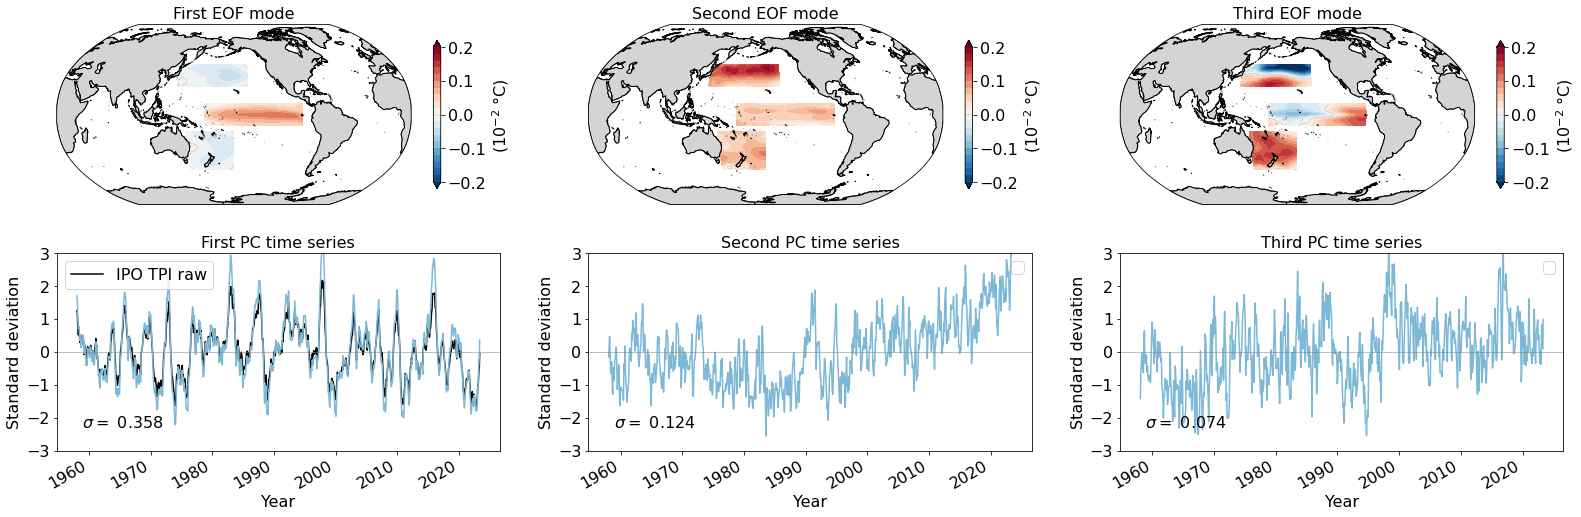

In [17]:
%%time
titles = ['First', 'Second', 'Third']
plt.figure(figsize=(27,8))
for f in range(modes):
    if f == 0: titles
    # ---- ---- ---- first the spatial patterns
    ax1 = plt.subplot(2,modes,f+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    if f == 0:
        p1  = (-eofs[f,:,:]*1e2).plot.contourf(ax=ax1, levels = np.linspace(-.2,.2,21), cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p11 = (-eofs[f,:,:]*1e2).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    else:
        p1  = (eofs[f,:,:]*1e2).plot.contourf(ax=ax1, levels = np.linspace(-.2,.2,21), cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p11 = (eofs[f,:,:]*1e2).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
    cb.set_label(label='(10$^{-2}$ °C)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(titles[f] + ' EOF mode', fontsize=16)
    fancy_plot(ax1); ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
   
    # ---- ---- ---- now the time series
    plt.subplot(2,modes,f+3+1); 
    if f == 0: 
        TPI_JRA55_raw.plot(label='IPO TPI raw', c = 'k')
        (-1*pcs[:,f]).plot(c=rotblau[14], label=None); plt.axhline(0, c='grey', linewidth=.5); plt.ylim([-3,3])
    else:
        pcs[:,f].plot(c=rotblau[14], label=None); plt.axhline(0, c='grey', linewidth=.5); plt.ylim([-3,3])
    plt.text(TPI_JRA55_raw.time[10],-2.3, r'$\sigma = $ ' + str(np.round(variance[f].values, 3)), fontsize=16);    plt.ylabel('Standard deviation', fontsize=16) 
    plt.legend(fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title(titles[f] + ' PC time series', fontsize=16); plt.xlabel('Year', fontsize=16)
    
# --- saving as 300 dpi .PNG image in specified folder --------------------- #
plt.savefig(save + 'IPO_TPI_EOF_analysis_first_three_modes', 
            dpi=300, facecolor='w',                                          #
            edgecolor='w', orientation='landscape',                          #
            format=None, transparent=False, bbox_inches='tight',             #
            pad_inches=0.1, metadata=None)                                   #
# --- end of script -------------------------------------------------------- # 
# Wall time: 21.1 s

### Globally reconstructed figure 

CPU times: user 13.9 s, sys: 3.24 s, total: 17.1 s
Wall time: 14.4 s


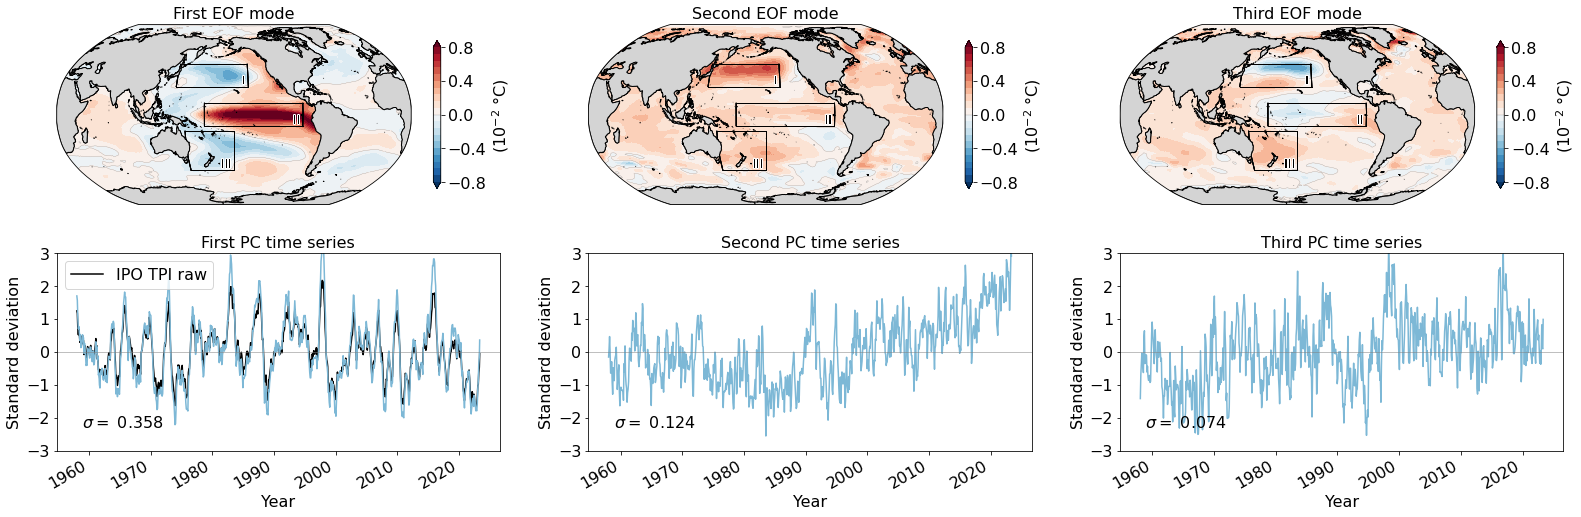

In [18]:
%%time
titles = ['First', 'Second', 'Third']
ticks = np.linspace(-.8,.8,21)
plt.figure(figsize=(27,8))
for f in range(modes):
    # ---- ---- ---- first the spatial patterns
    ax1 = plt.subplot(2,modes,f+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    if f == 0: full_spatial = ((-pcs[:,f] * jra55_ssta) / np.std(-pcs[:,f])).mean('time')
    else: full_spatial = ((pcs[:,f] * jra55_ssta) / np.std(-pcs[:,f])).mean('time')
    p1  = (full_spatial).plot.contourf(ax=ax1, levels=ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = (full_spatial).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #
    for r in range(3): # loop through the three regions
        if r == 0: TPI_bnds = [140, 215,  25,  45]; region = 'I'
        if r == 1: TPI_bnds = [170, 270, -10,  10]; region = 'II'
        if r == 2: TPI_bnds = [150, 200, -50, -15]; region = 'III'
        for d in range(4):
            txt = plt.plot([TPI_bnds[0],TPI_bnds[0]], [TPI_bnds[2], TPI_bnds[3]], color = 'k', linewidth=1, transform=ccrs.PlateCarree(),) # left line
            txt = plt.plot([TPI_bnds[1],TPI_bnds[1]], [TPI_bnds[2], TPI_bnds[3]], color = 'k', linewidth=1, transform=ccrs.PlateCarree(),) # right line
            txt = plt.plot([TPI_bnds[0],TPI_bnds[1]], [TPI_bnds[2], TPI_bnds[2]], color = 'k', linewidth=1, transform=ccrs.PlateCarree(),) # bottom line
            txt = plt.plot([TPI_bnds[0],TPI_bnds[1]], [TPI_bnds[3], TPI_bnds[3]], color = 'k', linewidth=1, transform=ccrs.PlateCarree(),) # top line
        txt = plt.text(TPI_bnds[1]-3,TPI_bnds[2]+5, region, va='center',transform=ccrs.PlateCarree(), fontsize = 12, ha='right') # include N34 value in plot
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
    cb.set_label(label='(10$^{-2}$ °C)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(titles[f] + ' EOF mode', fontsize=16)
    fancy_plot(ax1); ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
   
    # ---- ---- ---- now the time series
    plt.subplot(2,modes,f+3+1); 
    if f == 0: 
        TPI_JRA55_raw.plot(label='IPO TPI raw', c = 'k')
        (-1*pcs[:,f]).plot(c=rotblau[14], label=None); plt.axhline(0, c='grey', linewidth=.5); plt.ylim([-3,3]); plt.legend(fontsize=16)
    else:
        pcs[:,f].plot(c=rotblau[14], label=None); plt.axhline(0, c='grey', linewidth=.5); plt.ylim([-3,3])
    plt.text(TPI_JRA55_raw.time[10],-2.3, r'$\sigma = $ ' + str(np.round(variance[f].values, 3)), fontsize=16);    plt.ylabel('Standard deviation', fontsize=16) 
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title(titles[f] + ' PC time series', fontsize=16); plt.xlabel('Year', fontsize=16)
    
# --- saving as 300 dpi .PNG image in specified folder --------------------- #
plt.savefig(save + 'IPO_TPI_EOF_analysis_first_three_modes_reconstructed', 
            dpi=300, facecolor='w',                                          #
            edgecolor='w', orientation='landscape',                          #
            format=None, transparent=False, bbox_inches='tight',             #
            pad_inches=0.1, metadata=None)                                   #
# --- end of script -------------------------------------------------------- # 
# Wall time: 21.1 s

### Plotting the linear trend of the spatial anomalies over the June 2015 to December 2022 period

In [19]:
v = 1
field = xr.open_dataset(base + 'JRA55-do-1-5-0_' + var[v] +'_monthly_anom_1958-2023.nc')[var[v]]
field = field[-(trend_period*12):780,:,:] # only take Jan-1958 to Dec-2022 as the last few data points are of low quality according to Andrew Kiss
# field = (field.polyfit(dim = "time", deg = 1) * 3.17098e17).polyfit_coefficients[0,:,:] # convert linear trend from [(ns)^{-1}] to [year^{-1}]
# (field/100).plot()
field

<xarray.DataArray 'psl' (time: 91, lat: 320, lon: 640)>
[18636800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2015-06-15T22:30:00 ... 2022-12-16T10:30:00
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57

In [20]:
1e9  * 60  * 60  * 24 * 365

3.1536e+16

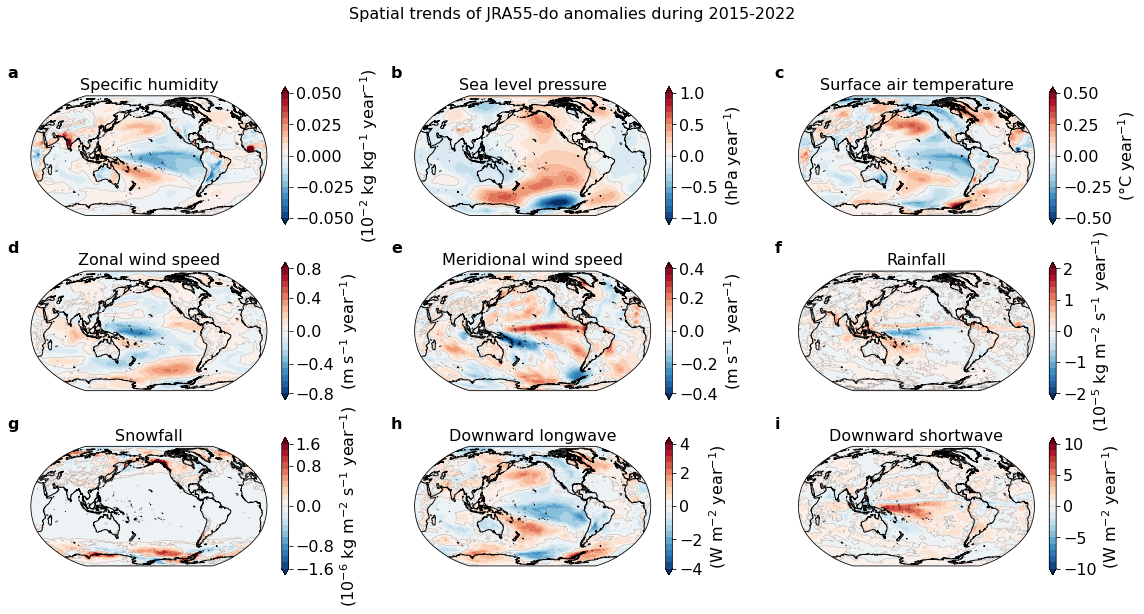

In [21]:
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
vars = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']
var  = ['huss', 'psl', 'tas', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds']
var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
var_units = ['10$^{-2}$ kg kg$^{-1}$ year$^{-1}$', 'hPa year$^{-1}$', '°C year$^{-1}$', 'm s$^{-1}$ year$^{-1}$', 'm s$^{-1}$ year$^{-1}$',
             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$ year$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$ year$^{-1}$', 'W m$^{-2}$ year$^{-1}$', 'W m$^{-2}$ year$^{-1}$', 'kg m$^{-2}$ s$^{-1}$ year$^{-1}$']

# (16,9)
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

for v in range(9): # loop through all variables
    # load in the data
    if v <= 8: 
        field = xr.open_dataset(base + 'JRA55-do-1-5-0_' + var[v] +'_monthly_anom_1958-2023.nc')[var[v]]
        field = field[-(trend_period*12):780,:,:] # only take Jan-1958 to Dec-2022 as the last few data points are of low quality according to Andrew Kiss

    field = (field.polyfit(dim = "time", deg = 1) * 1e9  * 60  * 60  * 24 * 365).polyfit_coefficients[0,:,:]

    if v == 0: scale = 1e2;  ticks = np.linspace(-.1,.1,21)   # huss
    if v == 1: scale = 1e-2; ticks = np.linspace(-2,2,21)   # psl -> convert to hPa
    if v == 2: scale = 1;    ticks = np.linspace(-1,1,21)     # tas
    if v == 3: scale = 1;    ticks = np.linspace(-1.5,1.5,21)     # uas
    if v == 4: scale = 1;    ticks = np.linspace(-.75,.75,21) # vas
    if v == 5: scale = 1e5;  ticks = np.linspace(-4,4,21)     # prrn 
    if v == 6: scale = 1e6;  ticks = np.linspace(-2.5,2.5,21)     # prsn
    if v == 7: scale = 1;    ticks = np.linspace(-7.5,7.5,21)   # rlds
    if v == 8: scale = 1;    ticks = np.linspace(-20,20,21)   # rsds
    # if v == 9: scale = 1e-4; ticks = np.linspace(-5,5,21)   # friver   

    ax1 = plt.subplot(3,3,v+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    # ------------------------------------ #
    p1  = (field*scale).plot.contourf(ax=ax1, levels=ticks/2, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = (field*scale).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.55, orientation='vertical'); 
    cb.set_label(label='('+var_units[v]+')', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(var_titles[v], fontsize=16)
    fancy_plot(ax1)
    ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Spatial trends of JRA55-do anomalies during 2015-2022', fontsize=16)
    
    if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
    if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])
    
    # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    plt.savefig(save + 'Linear_trends_in_atm_forcing_fields_over_06-2015-12-2022' + suffix, 
                dpi=300, facecolor='w',                                          #
                edgecolor='w', orientation='landscape',                          #
                format=None, transparent=False, bbox_inches='tight',             #
                pad_inches=0.1, metadata=None)                                   #
    # --- end of script -------------------------------------------------------- # 
# Wall time: 2min 2s

### Same plot but with a SouthPolarStereo projection

In [22]:
%%time
import matplotlib.path as mpath 
def fancy_plot2(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    # ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)

CPU times: user 5 µs, sys: 5 µs, total: 10 µs
Wall time: 13.8 µs


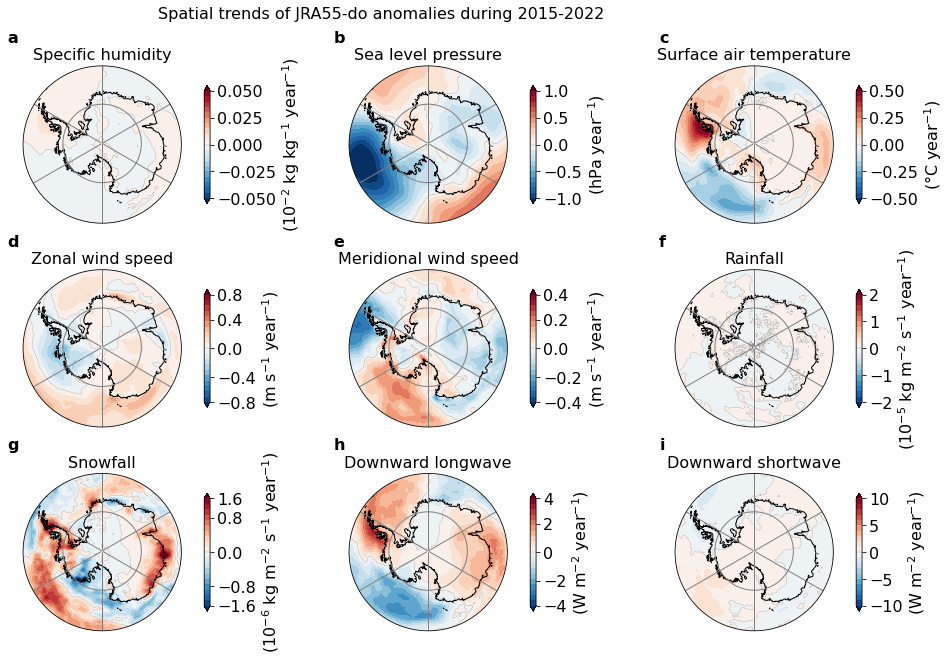

In [23]:
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
vars = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']
var  = ['huss', 'psl', 'tas', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds']
var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
var_units = ['10$^{-2}$ kg kg$^{-1}$ year$^{-1}$', 'hPa year$^{-1}$', '°C year$^{-1}$', 'm s$^{-1}$ year$^{-1}$', 'm s$^{-1}$ year$^{-1}$',
             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$ year$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$ year$^{-1}$', 'W m$^{-2}$ year$^{-1}$', 'W m$^{-2}$ year$^{-1}$', 'kg m$^{-2}$ s$^{-1}$ year$^{-1}$']

# (16,9)
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

for v in range(9): # loop through all variables
    # load in the data
    if v <= 8: 
        field = xr.open_dataset(base + 'JRA55-do-1-5-0_' + var[v] +'_monthly_anom_1958-2023.nc')[var[v]]
        field = field[-(trend_period*12):780,:,:] # only take Jan-1958 to Dec-2022 as the last few data points are of low quality according to Andrew Kiss

    field = (field.polyfit(dim = "time", deg = 1) * 1e9  * 60  * 60  * 24 * 365).polyfit_coefficients[0,:90,:] 


    if v == 0: scale = 1e2;  ticks = np.linspace(-.1,.1,21)   # huss
    if v == 1: scale = 1e-2; ticks = np.linspace(-2,2,21)   # psl -> convert to hPa
    if v == 2: scale = 1;    ticks = np.linspace(-1,1,21)     # tas
    if v == 3: scale = 1;    ticks = np.linspace(-1.5,1.5,21)     # uas
    if v == 4: scale = 1;    ticks = np.linspace(-.75,.75,21) # vas
    if v == 5: scale = 1e5;  ticks = np.linspace(-4,4,21)     # prrn 
    if v == 6: scale = 1e6;  ticks = np.linspace(-2.5,2.5,21)     # prsn
    if v == 7: scale = 1;    ticks = np.linspace(-7.5,7.5,21)   # rlds
    if v == 8: scale = 1;    ticks = np.linspace(-20,20,21)   # rsds
    # if v == 9: scale = 1e-4; ticks = np.linspace(-5,5,21)   # friver   

    ax1 = plt.subplot(3,3,v+1, projection=ccrs.SouthPolarStereo(central_longitude=0)) # longitude starting at Cape Agulhas (20°E)
    ax1.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
    # ------------------------------------ #
    p1  = (field*scale).plot.contourf(ax=ax1, levels=ticks/2, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = (field*scale).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
    cb.set_label(label='('+var_units[v]+')', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(var_titles[v], fontsize=16)
    fancy_plot2(ax1)
    ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Spatial trends of JRA55-do anomalies during 2015-2022', fontsize=16)
    
    if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
    if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])
    
    

    # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    plt.savefig(save + 'Linear_trends_in_atm_forcing_fields_over_06-2015-12-2022_SouthPolarStereo' + suffix, 
                dpi=300, facecolor='w',                                          #
                edgecolor='w', orientation='landscape',                          #
                format=None, transparent=False, bbox_inches='tight',             #
                pad_inches=0.1, metadata=None)                                   #
    # --- end of script -------------------------------------------------------- # 
# Wall time: 2min 2s

### Zoom into one sector of the Antarctic margin

In [24]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  

# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 30), # longitude grid lines
                  ylocs= np.linspace(0, -90, num=10)) # latitude grid lines
    ax.coastlines(); # add coast lines
    # theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    # circle = mpath.Path(verts * radius + center)
    # ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
    # xlab =    [ 3.2,    2.4,    1.1,    .12,     -.4,     .3,    .85] # x-position of labels
    xlab =    [    1,    -.03,   -.03,    .12,    .23,     .3,      .66]#,     .41] # x-position of labels
    ylab =    [  .72,      .7,    .52,    .21,   -.04,    1.02,    1.02]#,     .05] # y-position of labels
    txt_lab = ['60°W', '150°W', '60°S', '70°S', '78°S', '120°W', '90°W']#, '150°W'] # label text
    # loop through the 7 label and surround with white space for higher visibility
    if f == 0:
        for l in range(len(xlab)):
            ax.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                    fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])  
            
# loading in the unmasked coordinates
var = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'] # get the unmasked coordinates for plotting later on
for f in range(4):
    ds = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc')[var[f]] # get the dataset structure
    ds.values = xr.open_mfdataset('/g/data/ik11/grids/ocean_grid_01.nc')[var[f]].values # feed in the unmasked data into the dataset structure
    if f == 0: geolon_t = ds
    if f == 1: geolat_t = ds
    if f == 2: geolon_c = ds
    if f == 3: geolat_c = ds # I need the xarray.DataArray 'geolon_t' (yt_ocean: 2700xt_ocean: 3600) structure for later on calculating the make_boundary_path() function

CPU times: user 758 ms, sys: 536 ms, total: 1.29 s
Wall time: 1.61 s


CPU times: user 1.34 s, sys: 484 ms, total: 1.82 s
Wall time: 1.59 s


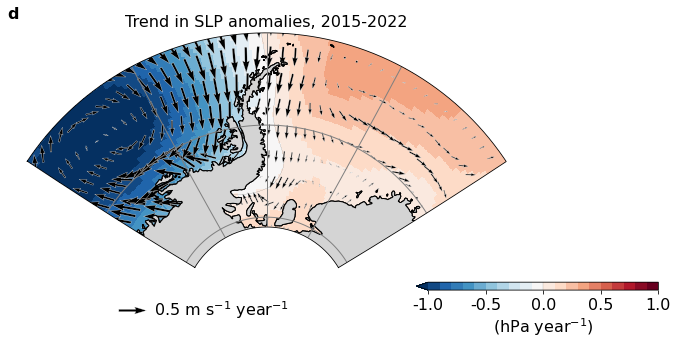

In [25]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(14, 11),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,4, width_ratios = [1,.3,.3,1], height_ratios = [1,.5,.5]) 

midlon = -60
maxlon = midlon + 60
minlon = midlon - 60
minlat = -90
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-1,1,21)
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00

var  = ['huss', 'psl', 'tas', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds']
for v in [1,3,4]: # loop through all variables
    field = xr.open_dataset(base + 'JRA55-do-1-5-0_' + var[v] +'_monthly_anom_1958-2023.nc')[var[v]]
    field = field[-(trend_period*12):780,:,:] # only take Jan-1958 to Dec-2022 as the last few data points are of low quality according to Andrew Kiss
    field = (field.polyfit(dim = "time", deg = 1) * 1e9  * 60  * 60  * 24 * 365).polyfit_coefficients[0,:90,:] 

    if v == 1: map_field = field/100 # sea level pressure in hPa
    if v == 3: uas_10m = field
    if v == 4: vas_10m = field
    
panel = gs[0,0:2]; titel = 'Trend in SLP anomalies, 2015-2022'

ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
ax1.coastlines(resolution='50m')

lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

boundary_path = make_boundary_path(lons, lats)
ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# ----------------------------------------------------------------------------------------------------------------------------------------- #
p1   = map_field.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap='RdBu_r', transform=ccrs.PlateCarree())
p11  = map_field.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
# 1000 dbar isobath
# p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
# ----------------------------------------------------------------------------------------------------------------------------------------- #
fancy_plot(ax1); # plt.suptitle('Shelf temperatures and surface wind stress', fontsize=16)          

plt.title(titel, fontsize=16)
ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# adding 10 m wind data
# specifics for the wind speed arrows
X = uas_10m.lon; Y = uas_10m.lat
U = uas_10m; V = vas_10m
# widths = np.linspace(-.0001, .0001, X.size)
# Add the wind stress arrows, only plotting every 30th data point.
skala = 3
Q = plt.quiver(to_np(X[::5]),      to_np(Y[::5]), 
               to_np(U[::5, ::5]), to_np(V[::5, ::5]), 
           scale=skala, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w')) 
                      # minshaft = select minimum sized arrow (i.e., only those larger than 2)
# reference key on the map
                    # x0,   y0, scale
qk = plt.quiverkey(Q, .25, 0, .3, r'0.5 m s$^{-1}$ year$^{-1}$', labelpos='E', fontproperties={'size':16}) 


                
# add colour bar .675
cax = fig.add_axes([.4125, .6, .24, .01]) # position: [x0, y0, width, height]
from matplotlib.ticker import FuncFormatter
fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
cb_txt = cb.set_label(label='(hPa year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks()
cb.add_lines(p11) # add contours to colour bar   

# Saving input files for ACCESS-OM2-01

### Creating combined RYF + anomalous forcing for ACCESS-OM2-01

In [44]:
%%time
# -------------------------------------------------------------------------------- #
trend_period = 2 # [years] specify over which period to calculate the linear trend #
# -------------------------------------------------------------------------------- #

# define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)
tstart = 2681 # start year of window in which scaling will be applied (1900 = initial time of control simulation)
seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

from scipy.interpolate import interp1d # using scipy here for the interpolation for N34 onto higher resolution
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
var = ['huss','psl','tas', 'uas','vas','prra','prsn','rlds','rsds','friver'] # only eight of the variables I used in my Msc
var2 = ['huss_10m','psl','tas_10m', 'uas_10m','vas_10m','prrn','prsn','rlds','rsds','friver']
var3 = ['q_10','slp','t_10', 'u_10','v_10','rain','snow','rlds','rsds','runoff_all'] # filename name variable on /g/data/ua8 for RYF forcing
  
for e in range(1): # loop through perturbation experiments
    if e == 0: 
        suffix = 'anomalous_trends_2015-2022'; save_folder = 'anomalous_trends_2015-2022/'
        print('Creating anomalous forcing fields for '+suffix+', '+str(trend_period)+'-yr EXP:')
        ts       = TPI_JRA55_raw                         # the full IPO TPI JRA55 time series [°C]
        ts       = ts / np.std(ts)                       # normalise the time series so it becomes unitless [ ]
        ts_short = TPI_JRA55_raw[-(trend_period*12):]    # the IPO TPI over the 2015-2022 period [°C]
        tend = tstart + trend_period # end year of window in which scaling will be applied
    print('---------------------------------------------------------------------------')
    
    for i in [2]:#range(len(var)): # loop through all variables
        if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['199001010000','199012312230']; length_year = 2920
        if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['199001010130','199101010000']; length_year = 2920
        if var[i] in ['friver']:                            domain = 'ocean/day/';   timestep = ['19900101','19910101'];         length_year = 365
        print(domain+var[i])
        
        # skip iteration if file already exists
        if os.path.isfile('/g/data/e14/mv7494/IPOAnt_input/'+save_folder+'RYF.'+var2[i]+'.1990_1991.nc') == True:
            print('Forcing file finished: RYF.'+var2[i]+'.1990_1991.nc')
            continue  
                
        # load in JRA55-do field, RYF field and copy the latter to get the correct .nc file structure
        # JRA_field = xr.open_dataset(base+domain+var[i]+'/gn/v20180412/'+var[i]+'_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-'+forcing+'_gn_'+timestep[0]+'-'+timestep[1]+'.nc')[var[i]]
        RYF_field = xr.open_dataset('/g/data/ua8/JRA55-do/RYF/v1-3/'+'RYF.'+var3[i]+'.1990_1991.nc')[var2[i]]
        # copy file structure to write the forcing data into it
        RYF_field_final = RYF_field.where(RYF_field > 27, other=0).where(RYF_field < 27, other=0) # copy file structure and fill with only zero values
                                                                                                  # later, I then fill up this array each time step with the forcing data

        # if var[i] != 'friver': # special case for the daily runoff field (all other fields are 3-hourly)                  
        #     anom = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_'+suffix[0:2]+'.nc')[var2[i]].load()
        # else: 
        #     pattern = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_'+suffix[0:2]+'_friver.nc')[var2[i]].load()
        
        anom = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-'+forcing+'/monthly_anom/'+'JRA55-do-'+forcing+'_'+
                               var[i]+'_monthly_anom_1958-2023.nc')[var[i]]
        anom = anom.rename({'lon': 'longitude','lat': 'latitude'}).load()

        # regress the IPO tripole index onto the anomaly field to get the regression pattern
        anom['time'] = TPI_JRA55_raw.time # copy over time structure, i.e., shift time axis by 1:30 hrs in SLP_anom so they align

        pattern = ((anom * TPI_JRA55_raw) / np.std(TPI_JRA55_raw)).mean(['time']) # do regression        
        
        # Matt's part from here
        # --------------------------------- part with leap day correction --------------------------------- #
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # Extract time series and structure from original files:
        timeRYF = RYF_field.time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        # interpolate the time series to correct temporal resolution of input file
        time_series = np.interp(np.linspace(1,len(ts_short),len((timeYR-zeroYR))), np.linspace(0,len(ts_short),len(ts_short)), ts_short)
        
        
        # ---  Here the key part: climatological forcing + anomalies (time series[t] * spatial pattern[x,y])  --- #
        # ------------------------------------------------------------------------------------------------------- #
        RYF_field_concat = xr.concat([RYF_field]*trend_period, dim='time') # first, concatenate climatological    #
                                                                          # forcing N times along time dimension  #
        for t in range(2920*trend_period):                                                                        #
            RYF_field_concat[t,:,:] = RYF_field_concat[t,:,:] + (pattern.values*time_series[t])                   #
        # ------------------------------------------------------------------------------------------------------- #
         
        RYF_field_concat.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/'+save_folder+'RYF.'+var2[i]+'.1990_1991.nc')
        print('Forcing file finished: RYF.'+var2[i]+'.1990_1991.nc')
    print('--- --- --- --- --- --- --- --- --- --- --- --- --- --- ---')
# Wall time: 1min 5s                           for 8 years and one variable when splitting up the RYF files into individual years
# Wall time: 4min 4s                           for 8 years and one variable when having just one long forcing file

Creating anomalous forcing fields for anomalous_trends_2015-2022, 2-yr EXP:
---------------------------------------------------------------------------
atmos/3hrPt/tas
Forcing file finished: RYF.tas_10m.1990_1991.nc
--- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
CPU times: user 17.7 s, sys: 14.5 s, total: 32.2 s
Wall time: 33.2 s


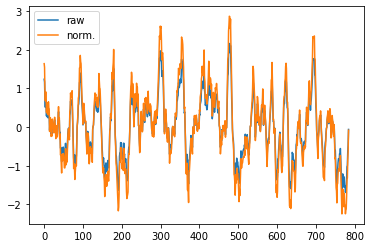

In [34]:
plt.plot(TPI_JRA55_raw, label='raw')
plt.plot(TPI_JRA55_raw / np.std(TPI_JRA55_raw), label = 'norm.'); plt.legend()

Text(0.5, 1.0, 'IPO regression map (e.g., SAT (°C))')

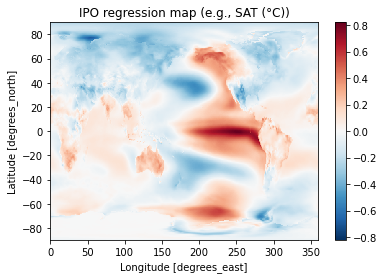

In [42]:
pattern.plot(); plt.title('IPO regression map (e.g., SAT (°C))')

### Backup below here where I split the forcing into different years (e.g., yr1/, yr2/, yr3/, ...)

In [196]:
%%time
from scipy.interpolate import interp1d # using scipy here for the interpolation for N34 onto higher resolution
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
var = ['huss','psl','tas', 'uas','vas','prra','prsn','rlds','rsds','friver'] # only eight of the variables I used in my Msc
var2 = ['huss_10m','psl','tas_10m', 'uas_10m','vas_10m','prrn','prsn','rlds','rsds','friver']
var3 = ['q_10','slp','t_10', 'u_10','v_10','rain','snow','rlds','rsds','runoff_all'] # filename name variable on /g/data/ua8 for RYF forcing
  
for e in [0]:#range(2): # loop through perturbation experiments
    if e == 0: 
        suffix = 'anomalous_trends_2015-2022'; save_folder = 'anomalous_trends_2015-2022/'
        print('Creating anomalous forcing fields for '+suffix+', '+str(trend_period)+'-yr EXP:')
        ts       = TPI_JRA55_raw                      # the full IPO TPI JRA55 time series [°C]
        ts_short = TPI_JRA55_raw[-(trend_period*12):] # the IPO TPI over the 2015-2022 period [°C]
    print('---------------------------------------------------------------------------')
    
    for i in [2]:#range(len(var)): # loop through all variables
        if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['199001010000','199012312230']; length_year = 2920
        if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['199001010130','199101010000']; length_year = 2920
        if var[i] in ['friver']:                            domain = 'ocean/day/';   timestep = ['19900101','19910101'];         length_year = 365
        print(domain+var[i])
        
        # load in JRA55-do field, RYF field and copy the latter to get the correct .nc file structure
        # JRA_field = xr.open_dataset(base+domain+var[i]+'/gn/v20180412/'+var[i]+'_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-'+forcing+'_gn_'+timestep[0]+'-'+timestep[1]+'.nc')[var[i]]
        RYF_field = xr.open_dataset('/g/data/ua8/JRA55-do/RYF/v1-3/'+'RYF.'+var3[i]+'.1990_1991.nc')[var2[i]]
        # copy file structure to write the forcing data into it
        RYF_field_final = RYF_field.where(RYF_field > 27, other=0).where(RYF_field < 27, other=0) # copy file structure and fill with only zero values
                                                                                                  # later, I then fill up this array each time step with the forcing data

        # if var[i] != 'friver': # special case for the daily runoff field (all other fields are 3-hourly)                  
        #     anom = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_'+suffix[0:2]+'.nc')[var2[i]].load()
        # else: 
        #     pattern = xr.open_dataset('/g/data/e14/mv7494/ENSOAnt_input/spatial_patterns/sp_mean_anoms_'+suffix[0:2]+'_friver.nc')[var2[i]].load()
        
        anom = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-'+forcing+'/monthly_anom/'+'JRA55-do-'+forcing+'_'+
                               var[i]+'_monthly_anom_1958-2023.nc')[var[i]]
        anom = anom.rename({'lon': 'longitude','lat': 'latitude'}).load()

        # regress the IPO tripole index onto the anomaly field to get the regression pattern
        anom['time'] = TPI_JRA55_raw.time # copy over time structure, i.e., shift time axis by 1:30 hrs in SLP_anom so they align

        pattern = ((anom * TPI_JRA55_raw) / np.std(TPI_JRA55_raw)).mean(['time']) # do regression        
        
        # Matt's part from here
        # --------------------------------- part with leap day correction --------------------------------- #
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # Extract time series and structure from original files:
        timeRYF = RYF_field.time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        # interpolate the time series to correct temporal resolution of input file
        time_series = np.interp(np.linspace(1,len(ts_short),len((timeYR-zeroYR))), np.linspace(0,len(ts_short),len(ts_short)), ts_short)
        
        if e == 0:          # np.interp(target length: either 2*2920 or 4*2920                        , original length, either 24 or 48 months , original time series)
            ts_short_highres = np.interp(np.linspace(1,len(ts_short),length_year*(int(len(ts_short)/12))), np.linspace(0,len(ts_short),len(ts_short)), ts_short)  
        # if e == 1: 
        #     N34_JRA_highres = np.interp(np.linspace(1,len(ts_short),length_year*(int(len(ts_short)/12))), np.linspace(0,len(ts_short),len(ts_short)), ts_short)
        # ---------------------------------------------------------------------------------------------------- #
        
        for f in range(1,trend_period+1,1): # loop through the number of years starting from Yr 1, Yr 2, Yr 3, ...., Yr X
            if f == 1: time_series = ts_short_highres[0:length_year] # 0:2920
            if f == 2: time_series = ts_short_highres[length_year:(2*length_year)] # 2920:5840
            if f == 3: time_series = ts_short_highres[(length_year*2):(3*length_year)] 
            if f == 4: time_series = ts_short_highres[(length_year*3):(4*length_year)]           
            if f == 5: time_series = ts_short_highres[(length_year*4):(5*length_year)] 
            if f == 6: time_series = ts_short_highres[(length_year*5):(6*length_year)]             
            if f == 7: time_series = ts_short_highres[(length_year*6):(7*length_year)] 
            
            # skip iteration if file already exists
            if os.path.isfile('/g/data/e14/mv7494/IPOAnt_input/'+save_folder+'yr'+str(f)+'/'+'RYF.'+var2[i]+'.1990_1991.nc') == True:
                print('Year '+str(f)+' file finished: RYF.'+var2[i]+'.1990_1991.nc')
                continue  

            # here the key part where I add the anomalies (pattern * time series) to the RYF forcing
            for t in range(length_year):
                # if t % 1000 == 0: print('time step: '+str(t)) # print every 1000th iteration to see how far the loop is ahead
                
                # --- Here the key part: climatological forcing + anomalies (time series[t] * spatial pattern[x,y]) --- #
                RYF_field_final[t,:,:] = RYF_field[t,:,:] + (pattern.values*time_series[t])                             #
                # ----------------------------------------------------------------------------------------------------- #
         
            RYF_field_final.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/'+save_folder+'yr'+str(f)+'/'+'RYF.'+var2[i]+'.1990_1991.nc')
            print('Year '+str(f)+' file finished: RYF.'+var2[i]+'.1990_1991.nc')
        print('--- --- --- --- --- --- --- --- --- --- --- --- --- --- ---')
# Wall time: 1min 5s                           for 8 years and one variable

Creating anomalous forcing fields for anomalous_trends_2015-2022, 8-yr EXP:
---------------------------------------------------------------------------
atmos/3hrPt/tas
Year 1 file finished: RYF.tas_10m.1990_1991.nc
Year 2 file finished: RYF.tas_10m.1990_1991.nc
Year 3 file finished: RYF.tas_10m.1990_1991.nc
Year 4 file finished: RYF.tas_10m.1990_1991.nc
Year 5 file finished: RYF.tas_10m.1990_1991.nc
Year 6 file finished: RYF.tas_10m.1990_1991.nc
Year 7 file finished: RYF.tas_10m.1990_1991.nc
Year 8 file finished: RYF.tas_10m.1990_1991.nc
--- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
CPU times: user 11.4 s, sys: 9.98 s, total: 21.4 s
Wall time: 20.9 s


### First saving the anomalous spatial patterns as .nc files
script based on the one from Ryan in 
/home/561/rmh561/access-om2/1deg_jra55v14_ryf_rcpWCWCpactest/ACCESS-OM2_OceanHeat_Make_Scaling.ipynb

and the one from Matt on github
https://github.com/mpudig/1deg_jra55_ryf/blob/v14_rcp_sinusoid_x1_period7/ACCESS-OM2_OceanHeat_Make_Scaling.ipynb

In [26]:
%%time

# first delete the files if they already exist as otherwise the script runs into problems --- #
# os.system('rm -r /g/data/e14/mv7494/IPOAnt_input/time_series/*')
# os.system('rm -r /g/data/e14/mv7494/IPOAnt_input/spatial_patterns/*')
# ------------------------------------------------------------------------------------------- #

# define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)
tstart = 2550 # start year of window in which scaling will be applied (1900 = initial time of control simulation)
seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

JRAout = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/' # Output location for storing scaling files created by this script
var  = ['q_10',     'slp', 't_10',    'u_10',    'v_10',    'rain', 'snow', 'rlds', 'rsds', 'runoff_all'] # input variables for ACCESS-OM2
var2 = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for JRA55-do-1-3
var3 = ['huss',     'psl', 'tas',     'uas',     'vas',     'prra', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for monthly JRA55-do-1-3 files

for n in range(1): # loop through the different simulations
    if n == 0: suffix = 'IPO_time_series_2015-2022'; tend = 2557 # end year of window in which scaling will be applied

    print('Creating forcing combining RYF & linear atmospheric trends over 2015-2022')
    print('-------------------------------------------------------------------------')
    
    for i in range(len(var)): # loop through all variables except taux and tauy
        # get the JRA55-do for the file structure
        if var[i] in ['q_10','slp','t_10','u_10','v_10']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']; length_year = 2920;
        if var[i] in ['rain','snow','rlds','rsds']:       domain = 'atmos/3hr/';   timestep = ['01010130','12312230']
        if var[i] in ['runoff_all']:                      domain = 'land/day/';    timestep = ['0101','1231'];         length_year = 365;
        print(domain+var[i])
        
        JRA_field = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var[i]+'.1990_1991.nc') 
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Creating time series files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        # Extract time series and structure from original files:
        timeRYF = JRA_field[var2[i]].time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        TPI_short = TPI_JRA55_raw[-(trend_period*12):] # the IPO TPI over the 2015-2022 period [°C]
        ts = TPI_short / np.std(TPI_short)    # normalise the time series             [°C/°C = unitless]
        
        # interpolate the time series to correct temporal resolution of input file
        if n == 0:      # np.interp(              target length           ,            original length              , original data)
            ts_interp = np.interp(np.linspace(1,24,len((timeYR-zeroYR))), np.linspace(0,len(ts),len(ts)), ts)

        # Create new Datasets:
        ds = xr.DataArray(ts_interp, dims=['time'], coords={'time': timeFULL}, attrs=JRA_field[var2[i]].attrs)
        DS_out = JRA_field.drop_vars(var2[i]).assign_coords({'time':timeFULL}) 
        DS_out[var2[i]] = ds
        DS_out.attrs.update({'title': 'Scaling for ' + DS_out.attrs['title']})
        DS_out.time.attrs.update(JRA_field.time.attrs) # get the right attribute from the JRA file
        DS_out.time.encoding['units'] = "days since '1900-01-01'" 
        if i == 0: ts_huss_10m = DS_out.huss_10m
        if i == 1: ts_psl      = DS_out.psl
        if i == 2: ts_tas_10m  = DS_out.tas_10m
        if i == 3: ts_uas_10m  = DS_out.uas_10m
        if i == 4: ts_vas_10m  = DS_out.vas_10m
        if i == 5: ts_prrn     = DS_out.prrn
        if i == 6: ts_prsn     = DS_out.prsn
        if i == 7: ts_rlds     = DS_out.rlds
        if i == 8: ts_rsds     = DS_out.rsds
        if i == 9: ts_friver   = DS_out.friver
        
        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Create spatial scaling files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        DS_out = JRA_field.isel(time=0)
        anom = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-'+forcing+'/monthly_anom/'+'JRA55-do-'+forcing+'_'+
                               var3[i]+'_monthly_anom_1958-2023.nc')[var3[i]]
        anom = anom.rename({'lon': 'longitude','lat': 'latitude'}).load()

        # regress the IPO tripole index onto the anomaly field to get the regression pattern
        anom['time'] = TPI_JRA55_raw.time # copy over time structure, i.e., shift time axis by 1:30 hrs in SLP_anom so they align

        DS_out[var2[i]] = ((anom * TPI_JRA55_raw) / np.std(TPI_JRA55_raw)).mean(['time']) # do regression
        DS_out['time'] = anom.time[0]
        # index['time'] = field.time # replace N34 time step values with the values from the field       

        if i == 0: huss_10m = DS_out.huss_10m#.drop(['height','huss_10m'])
        if i == 1: psl      = DS_out.psl
        if i == 2: tas_10m  = DS_out.tas_10m#.drop(['height','tas_10m'])
        if i == 3: uas_10m  = DS_out.uas_10m#.drop(['height','uas_10m'])
        if i == 4: vas_10m  = DS_out.vas_10m#.drop(['height','vas_10m'])
        if i == 5: prrn     = DS_out.prrn#.drop(['prrn'])
        if i == 6: prsn     = DS_out.prsn#.drop(['prsn'])
        if i == 7: rlds     = DS_out.rlds#.drop(['rlds'])
        if i == 8: rsds     = DS_out.rsds#.drop(['rsds'])
        if i == 9: friver   = DS_out.friver#.drop(['friver'])

   # saving the time series back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': ts_huss_10m, 'psl': ts_psl, 'tas_10m': ts_tas_10m,
                      'uas_10m': ts_uas_10m, 'vas_10m': ts_vas_10m,
                      'prrn': ts_prrn, 'prsn': ts_prsn,
                      'rlds': ts_rlds, 'rsds': ts_rsds})
    DS4.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/time_series/ts_'+suffix+'.nc')  

    # separate file for friver as it has a resolution of (730)
    ts_friver.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/time_series//ts_'+suffix+'_friver.nc')  
    
    # saving the spatial patterns back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': huss_10m, 'psl': psl, 'tas_10m': tas_10m,
                      'uas_10m': uas_10m, 'vas_10m': vas_10m,
                      'prrn': prrn, 'prsn': prsn,
                      'rlds':rlds, 'rsds': rsds})

    DS4.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/spatial_patterns/sp_'+suffix+'.nc')  
    friver.to_netcdf('/g/data/e14/mv7494/IPOAnt_input/spatial_patterns/sp_'+suffix+'_friver.nc')  
        
    print('----------------------------------------------------------')
# Wall time: 43.3 s       per variable 
# Wall time: 16min 30s for all variables

Creating forcing combining RYF & linear atmospheric trends over 2015-2022
-------------------------------------------------------------------------
atmos/3hrPt/q_10
atmos/3hrPt/slp
atmos/3hrPt/t_10
atmos/3hrPt/u_10
atmos/3hrPt/v_10
atmos/3hr/rain
atmos/3hr/snow
atmos/3hr/rlds
atmos/3hr/rsds
land/day/runoff_all
----------------------------------------------------------
CPU times: user 26.3 s, sys: 22.4 s, total: 48.7 s
Wall time: 50.5 s


In [27]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #

In [28]:
def how_long_till_i_am_rich(investment, profit_goal, interest_rate):
    profit = 0
    days = 0
    daily_interest = interest_rate / 100 / 365
    while profit < profit_goal:
        days += 1
        profit += (investment + profit) * daily_interest
    years = days // 365
    months = days % 365 // 30
    days = days - (months * 30) - (years * 365)
    return years, months, days
years, months, days = how_long_till_i_am_rich(14234.84, 1e6, 0.022)
print(f"It would take {years} years, {months} months, and {days} days")

It would take 19391 years, 9 months, and 27 days
